In [1]:
import numpy as np
import keras
import keras.backend as K
import pyjet

from data_utils import RoadData

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


PyJet is using CUDA.


In [2]:
trainset = RoadData().load_train()
traingen = trainset.flow(batch_size=8, shuffle=False)
batch_x, batch_y = next(traingen)
batch_y.shape

100%|██████████| 10897/10897 [00:18<00:00, 581.56it/s]


X shape: (10897,)
Y Shape: (10897,)


(8, 512, 512, 1)

In [18]:
from pyjet.layers import AveragePooling2D
import pyjet.backend as J
import torch

print(J.channels_mode)

# Create the edge model
def edge_detector(y_true, pool_size=11):
    y_true = y_true.transpose(0, 3, 1, 2)
    
    y_true = J.from_numpy(y_true)
    averaged_mask = AveragePooling2D(pool_size, stride=1, padding='same')(y_true)
    w0 = J.sum(torch.ones_like(averaged_mask))
    weight = 5. * torch.exp(-5. * torch.abs(averaged_mask - 0.5))
    w1 = J.sum(weight)
    weight = weight * (w0 / w1)[:, None, None, None]
    
    weight = J.to_numpy(weight)
    weight = weight.transpose(0, 2, 3, 1)
    
    return weight

channels_first


In [52]:
batch_y = batch_y.astype(np.float32, copy=False)
edges = edge_detector(batch_y, pool_size=21)
print(edges.shape)
print(edges.min())
print(edges.max())

(8, 512, 512, 1)
0.38030207
10.429226


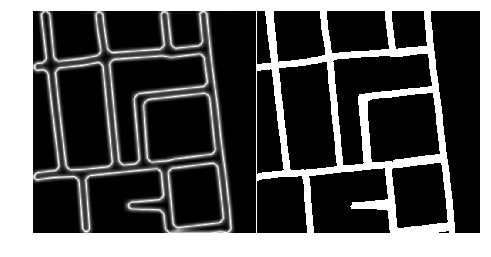

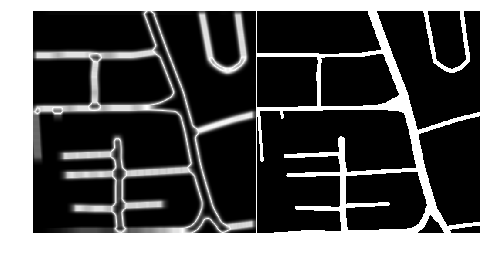

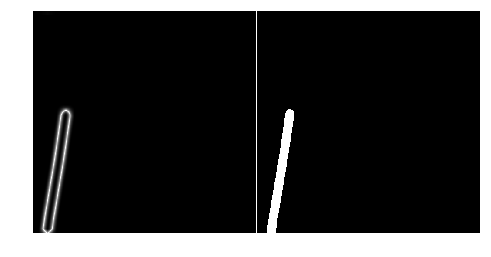

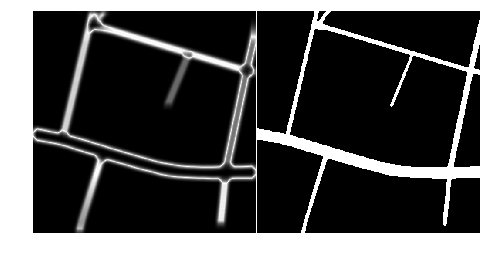

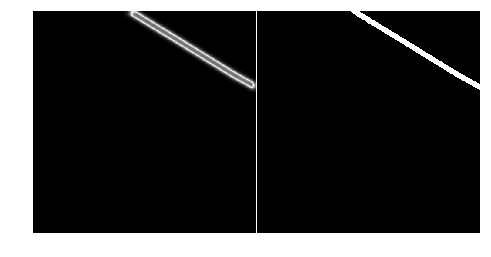

In [53]:
from plot_utils import plot_img_grid

edges = list(edges)
actuals = list(batch_y)
for edge, actual in zip(edges, actuals):
    if actual.sum():
        plot_img_grid([edge, actual])